In [1]:
cd ..

/gpfs01/bethge/home/mkuemmerer/Documents/Uni/Bethge/Saliency/pysaliency


In [2]:
from __future__ import print_function

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

Pysaliency
==========

Pixel Space Information Gain evaluation
-------------------------------

This notebook demonstrates how `pysaliency` can be used for pixel space information gain evaluation as demonstrated in [Information-theoretic model comparison unifies saliency metrics](http://dx.doi.org/10.1073/pnas.1510393112).

In [5]:
import pysaliency
import pysaliency.external_datasets

data_location = 'test_datasets'

In [6]:
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003_onesize(location=data_location)

In [7]:
# Create Gold Standard
nonlin = np.array([  3.49507791e-07,   1.47168761e-03,   2.60373129e-01,
         2.84424917e-01,   3.08476675e-01,   3.32528425e-01,
         3.56580184e-01,   3.80631940e-01,   4.04683699e-01,
         4.52998401e-01,   5.37440596e-01,   6.21882777e-01,
         7.07076345e-01,   7.43299728e-01,   7.50094183e-01,
         7.54579454e-01,   7.65437037e-01,   7.73176970e-01,
         7.79269978e-01,   7.85573526e-01])

blur_radius = 28.434119632171214

fixation_maps = pysaliency.FixationMap(mit_stimuli, mit_fixations)
gold_standard = pysaliency.SaliencyMapConvertor(saliency_map_model = fixation_maps,
                                                nonlinearity = nonlin,
                                                centerbias = [0,1],
                                                blur_radius = blur_radius,
                                                saliency_min = 0.0,
                                                saliency_max = 1.0)

/gpfs01/bethge/home/mkuemmerer/envs/workstations/local/lib/python2.7/site-packages/theano/tensor/subtensor.py:138: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  start in [None, 0] or
/gpfs01/bethge/home/mkuemmerer/envs/workstations/local/lib/python2.7/site-packages/theano/tensor/subtensor.py:142: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  stop in [None, length, maxsize] or
/gpfs01/bethge/home/mkuemmerer/envs/workstations/local/lib/python2.7/site-packages/theano/tensor/opt.py:1895: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx.start not in [0, None]:


In [8]:
# Create model to test (here: Bruce and Tsotso's AIM)
aim_saliency_map = pysaliency.AIM(location='test_models',
                                  cache_location=os.path.join('cache', 'model_caches', 'AIM'))

nonlin = np.array([  1.00000000e-20,   9.52115109e-03,   9.52115109e-03,
         9.52115109e-03,   9.52115109e-03,   9.52115109e-03,
         9.52115109e-03,   1.43374750e-02,   1.65030156e-02,
         3.53915883e-02,   7.60503511e-02,   1.45195547e-01,
         2.54740120e-01,   4.24345827e-01,   6.71119681e-01,
         1.49092060e+00,   1.66344216e+00,   1.71643371e+00,
         1.71662445e+00,   1.71776858e+00])

centerbias = np.array([ 3.28157057,  2.76741857,  1.91055761,  1.36368871,  0.91901744,
        0.65788018,  0.39153874,  0.22558925,  0.1729419 ,  0.16437142,
        0.12902333,  0.01640229])

alpha = 1.0

blur_radius = 28.7859674143928

probabilistic_aim = pysaliency.SaliencyMapConvertor(saliency_map_model = aim_saliency_map,
                                                    nonlinearity = nonlin,
                                                    centerbias = centerbias,
                                                    alpha = alpha,
                                                    blur_radius = blur_radius,
                                                    saliency_min = 5.2512888815495984,
                                                    saliency_max = 507.94043954390355)

In [9]:
stimulus_index = 10
stimulus = mit_stimuli[stimulus_index]

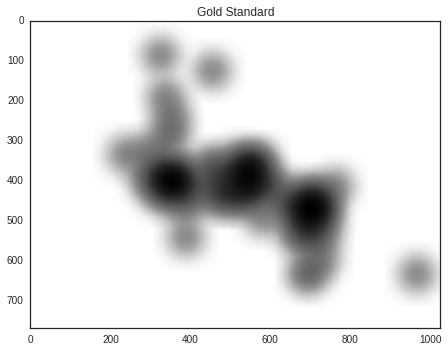

In [10]:
plt.imshow(gold_standard.log_density(stimulus))
plt.title('Gold Standard');

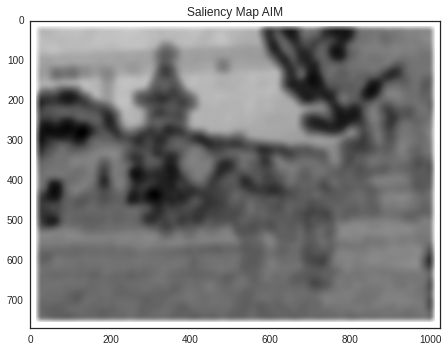

In [11]:
smap = aim_saliency_map.saliency_map(stimulus)
plt.imshow(smap)
plt.title("Saliency Map AIM");

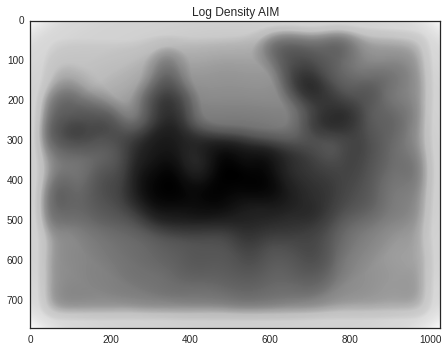

In [12]:
log_densities = probabilistic_aim.log_density(stimulus)
plt.imshow(log_densities)
plt.title("Log Density AIM");

In [17]:
from scipy.misc import logsumexp
from scipy.ndimage.filters import gaussian_filter

def normalize_fixations(stimuli, fixations):
    xs = []
    ys = []
    for n in range(len(stimuli)):
        this_fix = fixations[fixations.n == n]
        height, width = stimuli.sizes[n]
        this_xs = this_fix.x / width * 1.0
        this_ys = this_fix.y / height * 1.0
        xs.extend(this_xs)
        ys.extend(this_ys)
    
    return xs, ys

class BaselineModel(pysaliency.Model):
    def __init__(self, stimuli, fixations, bandwidth, eps = 1e-20, **kwargs):
        super(BaselineModel, self).__init__(**kwargs)
        self.stimuli = stimuli
        self.fixations = fixations
        self.bandwidth = bandwidth
        self.eps = eps
        self.xs, self.ys = normalize_fixations(stimuli, fixations)
        #self.kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(np.vstack([self.xs, self.ys]).T)
        self.shape_cache = {}
    
    def _log_density(self, stimulus):
        shape = stimulus.shape[0], stimulus.shape[1]
        if shape not in self.shape_cache:


            #print(XX)
            #print(YY)
            if False:
                XX, YY = np.mgrid[:shape[0],:shape[1]]
                XX = XX.astype(np.float)
                YY = YY.astype(np.float)
                XX /= shape[1]
                YY /= shape[0]
                grid_data = np.array([XX.ravel(), YY.ravel()]).T
                Z = self.kde.score_samples(grid_data)
                ZZ = Z.reshape(XX.shape)
            else:
                ZZ = np.zeros(shape)
                for x, y in (zip(self.xs, self.ys)):
                    ZZ[y*shape[0], x*shape[1]] += 1
                ZZ = gaussian_filter(ZZ, [self.bandwidth*shape[0], self.bandwidth*shape[1]])
                ZZ += self.eps
                ZZ = np.log(ZZ)
                
            ZZ -= logsumexp(ZZ)
            #ZZ -= np.log(np.exp(ZZ).sum())
            self.shape_cache[shape] = ZZ
            
        return self.shape_cache[shape]

In [18]:
baseline = BaselineModel(mit_stimuli, mit_fixations, 0.035938136638046257, eps=1e-20)

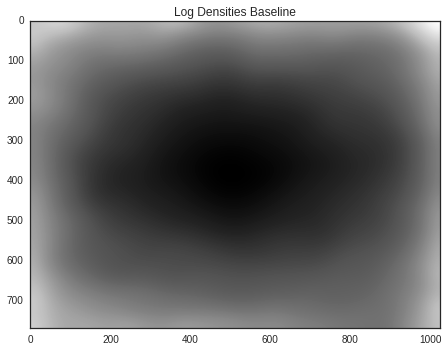

In [19]:
plt.imshow(baseline.log_density(stimulus));
#plt.colorbar();
plt.title('Log Densities Baseline');

In [22]:
ig = probabilistic_aim.pixel_space_information_gain(baseline, gold_standard, stimulus)

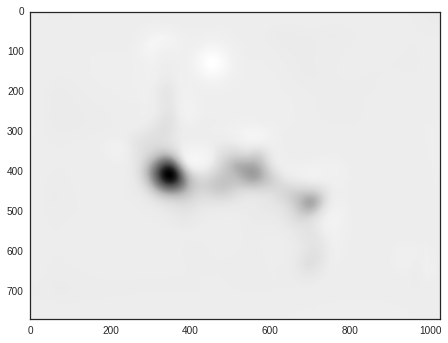

In [23]:
plt.imshow(ig)

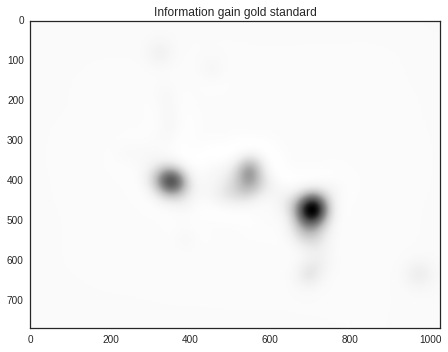

In [37]:
ig_gold = gold_standard.pixel_space_information_gain(baseline, gold_standard, stimulus)
plt.imshow(ig_gold)
plt.title('Information gain gold standard');

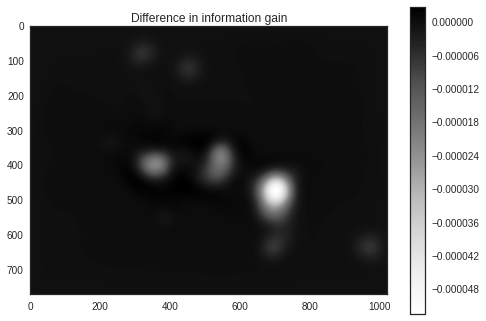

In [25]:
plt.imshow(ig - ig_gold)
plt.title('Difference in information gain');
plt.colorbar();

In [32]:
from pysaliency.plotting import plot_information_gain

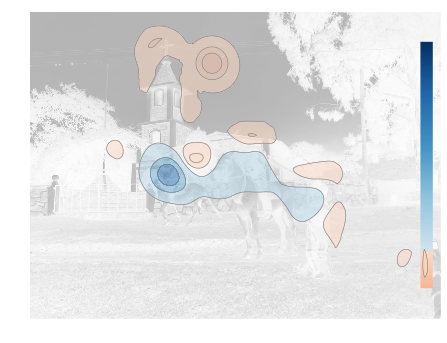

In [110]:
plot_information_gain(ig, image=stimulus.stimulus_data)

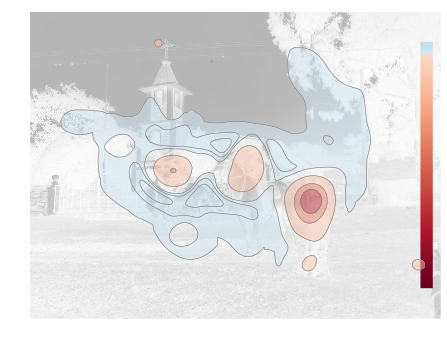

In [113]:
plot_information_gain(ig-ig_gold, image=stimulus.stimulus_data)

In [41]:
inds = range(5)
igs = []
ig_golds = []
ig_diffs = []
for i in inds:
    igs.append(probabilistic_aim.pixel_space_information_gain(baseline, gold_standard, mit_stimuli[i]))
    ig_golds.append(gold_standard.pixel_space_information_gain(baseline, gold_standard, mit_stimuli[i]))
    ig_diffs.append(igs[-1] - ig_golds[-1])

In [42]:
ig_min = np.min(igs)
ig_max = np.max(igs)

In [43]:
ig_diff_min = np.min(ig_diffs)
ig_diff_max = np.max(ig_diffs)

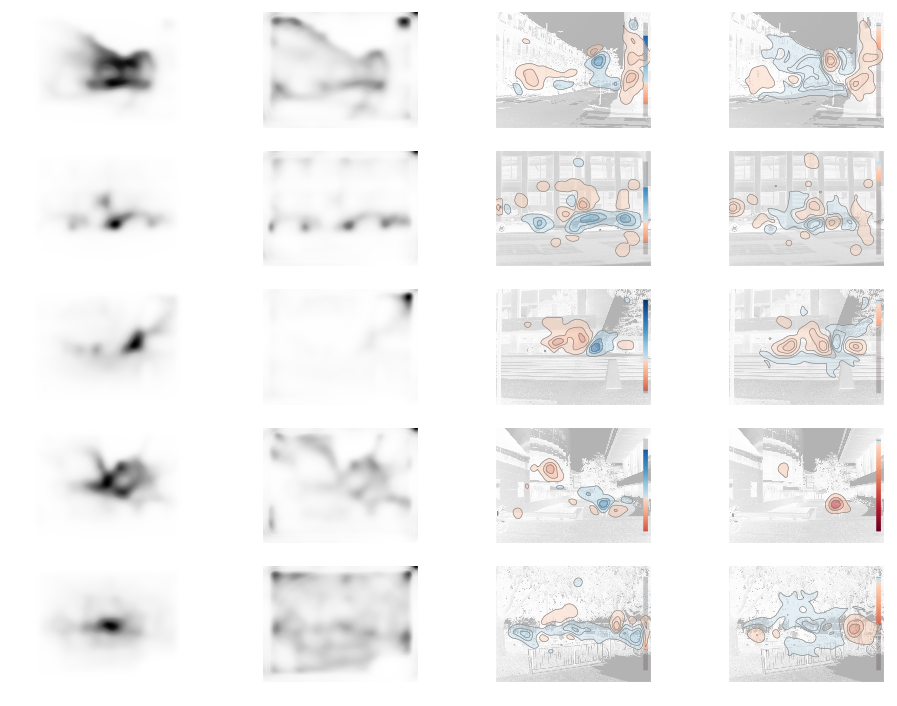

In [45]:
width = 4
f, axs = plt.subplots(len(inds), 4, figsize=(4*width,len(inds)*3/4*width))
for i in inds:
    p_model = np.exp(probabilistic_aim.log_density(mit_stimuli[i]))
    p_baseline = np.exp(baseline.log_density(mit_stimuli[i]))
    axs[i, 0].imshow(p_model)
    axs[i, 0].set_axis_off()
    axs[i, 1].imshow(p_model / p_baseline)
    axs[i, 1].set_axis_off()
    plot_information_gain(igs[i], image=mit_stimuli[i].stimulus_data, color_range=(ig_min, ig_max),
                         ax=axs[i, 2])
    plot_information_gain(ig_diffs[i], image=mit_stimuli[i].stimulus_data, color_range=(ig_diff_min, ig_diff_max),
                         ax=axs[i, 3])